<center><h1>QBUS6840 - Predictive Analytics </h1></center>

# Tutorial 11 – Neural Networks I
 
### Objectives:

- Training a Feed Forward Neuron Network model using Keras
- Forecasting with Feed Forward Neuron Network
- Develop Python skills

In this tutorial we will take a timeseries, perform data pre-processing, split the processed data into train (in-sample) and test (out-of-sample) sets and then produce one-step-ahead forecasts using Feed Forward Neural Network (FNN or simply NN).

## 1. Install Keras

Keras provides a high-level approach to build, train and predict using neural networks. It is built on top of other neural network libraries like TensorFlow or Theano. It helps to quickly train and make prediction using neural network
based models. 

**Method 1:** Install Keras as a Tensorflow API (we will go for this option)

1. From Anaconda Prompt, install Tensorflow using pip (https://www.tensorflow.org/install)
```python
pip install --upgrade pip        # Requires the latest pip
pip install tensorflow           # Current stable release for CPU and GPU
```
2. Import Keras modules from Tensorflow
```python
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
```

**Method 2:** Install Keras as a standardalone package from conda-forge 

If you do not have Keras installed already, you can type the following on the Windows Command Prompt or Terminal on OS X.

```python
conda install –c conda-forge keras
```

If you have trouble with install the Keras package, you can refer to the installation guideline on Canvas or the official online tutorial:

https://github.com/keras-team/keras


## 2. Import required libraries/functions and load the data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

Make sure to convert the pandas dataframe to an array by using `.values` attribute. `Keras` expects array data type, not `DataFrame` or `Series`.

data_not_scaled 144


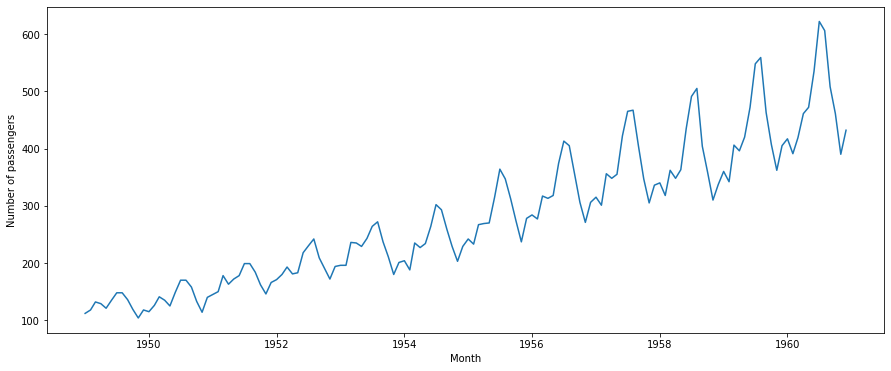

In [3]:
data_raw = pd.read_csv('AirPassengers.csv')
data_raw['Month'] = pd.to_datetime(data_raw['Month']) # Convert the data in the Month column to datetime
data_raw.set_index('Month', inplace=True)             # Indexing the DataFrame by the Month column

# Convert data from Dataframe to array
# We name the new data as data_not_scaled as we will scale the data later on
data_not_scaled = data_raw.dropna()               # Drop all Nans
data_not_scaled = data_not_scaled.values          # Convert from DataFrame to Python Array
data_not_scaled = data_not_scaled.astype('float') # You need to make sure the data is type of float
print("data_not_scaled", len(data_not_scaled))

# Plot the time series
plt.figure(figsize=(15,6))
plt.plot(data_raw.index,data_not_scaled)
plt.xlabel('Month')
plt.ylabel('Number of passengers')
plt.show()

## 3. Data pre-processing and train/test split

Naturally, the NN models are designed to work with the **cross-sectional** data (or tabular data), where data are presented in tabular format with rows (also called observations, data points, etc.) and columns, and the rows are assumed to be independent. Table columns contain samples of input features, $X=[x_1,...,x_p]$, and a single output variable $Y$. The purpose of using NN, and other regression models, is to approxiate the (true) function $f_{\text{true}}(X)$, which is unknown for real data, representing the relationship between input and output variables. In machine learning language, we call this as *supervised learning* task. 

**Note:** 
- The ***DirectMarketing*** data discussed in Lecture 10 is an example of cross-sectional data.
- The input variables are also called features, covariates, independent variables, etc. 
- The output variable is also called target, dependent variable, response, etc. 

Time series data (both univariate and multivariate cases), on the other hand, are not contructed in this way by nature (why?). For this reason, in order to use NN to model a given time series data (in this unit we are interested in only univariate time series), normally we need to take one more step to reconstruct the time series in a tabular format before passing data to the input layer of NN. 

For example, if we want to do one-step-ahead forecasting, our target is a single point (scalar value for univariate time series) for the next observation. The obvious choice for the features is the most recent observations in the timeseries. In other words, in our NN, we will use a small number of past observations to predict a single new observation. The figure below shows how to implement this approach in more details.  

<div style="margin-bottom: 0px;"><img width=400 src="FNN_data_construction.jpg"> </div>

How many past observations should we use to predict a new observation? The length of this window depends on a few things. First, we must consider whether there is seasonality in our data. If there is then to model the seasonality in our network the input feature window must be at least as long as the seasonal period. In this dataset the seasonal period is 12 months, e.g. $K=12$. If the time series don't exhibit seasonal effects, we can perform grid search for $K$.

Once the time series is reconstructed in the tabular format, we can use the first $T_{\text{in}}$ rows as training/in-sample data to train NN and use the last $T_{\text{out}}$ rows as the out-of-sample (test) data to access the forecast performance of the trained NN model. In this tutorial, let's use the first $80\%$ of rows for in-sample data and the last $20\%$ of rows for out-of-sample data.

Before doing data reconstruction, a data pre-processing step is oftern needed because neural networks normally work more efficient with scaled data. It is often that we scale the data to the range of $[0,1]$. This can be easily done by using scikit-learn's `MinMaxScaler()` function. 

**Note:** You can also use other ranges of scaling such as $[-1, 1]$ or standard scaler which scales using mean and standard deviation, e.g. normalisation. 

The code below shows how to use create a `MinMaxScaler()` object, compute the train and tets sizes, scale the data and then plot the scaled data. 

train_size 105
test_size 27


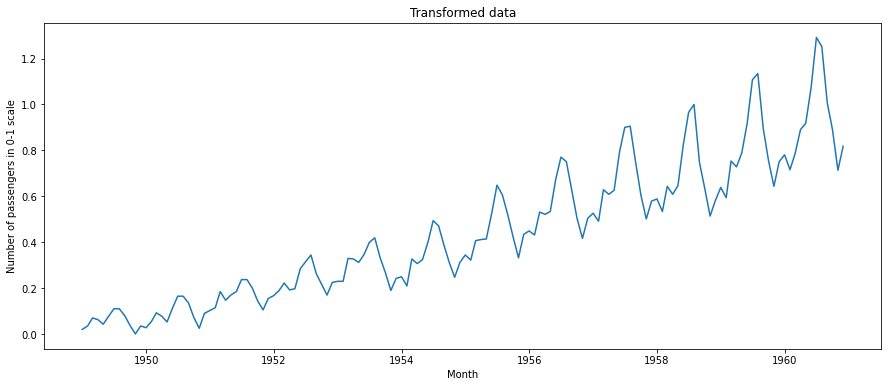

In [4]:
# Time window to define the number of features in each row
time_window = 12# seasonal pattern

# Define a scaler object
scaler = MinMaxScaler(feature_range=(0, 1)) #standerization
#把所有資料都放進0跟1之間 之後在把他 放大 回去原本的樣子
# Compute in-sample and out-of-sample size
train_size = int((len(data_not_scaled)-time_window) * 0.8)
print("train_size",train_size)
test_size = len(data_not_scaled) - train_size-time_window
print("test_size",test_size)

# Fitting the scaler
fitted_transformer = scaler.fit(data_not_scaled[:train_size+time_window])

# Transforming using trained scaler
data_scaled = fitted_transformer.transform(data_not_scaled)

# Plot the scaled data
plt.figure(figsize=(15,6))
plt.plot(data_raw.index,data_scaled)
plt.xlabel('Month')
plt.ylabel('Number of passengers in 0-1 scale')
plt.title('Transformed data')
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Explain how the in-sample and out-of-sample sizes are computed in lines 8-9?

You may notice that we don't use all data to perform the above scaling step. This is to to ensure no information leakage. More specifically, if we use all data to do the scaling, we are incorporating the information from the out-of-sample data. This will result in information leakage as in real life we don’t have any idea about the out-of-sample data, which is unseen. To ensure no information leakage, we use only in-sample data for scaling. Then we are using that trained scaler to transform out-of-sample data. So, if the out-of-sample data has higher value than the maximum value of in-sample data, it will have values greater than 1. This is evident from the plot of our transformed data

Given the scaled data, the following code will transform the scaled time series to a tabular (matrix) representation where rows are sliding/rolling window with a pre-defined window size. The window size is also the number of features, which is $K=12$.  

In [5]:
# Pre-allocation
Xall, Yall = [], []
Xall_not_scaled, Yall_not_scaled = [], []

# Use each rolling window as a row in the data matrix 
for i in range(time_window, len(data_scaled)):
    Xall.append(data_scaled[i-time_window:i, 0])
    Xall_not_scaled.append(data_not_scaled[i-time_window:i, 0])
    Yall.append(data_scaled[i, 0])
    Yall_not_scaled.append(data_not_scaled[i, 0])

# Convert them from list to array
Xall = np.array(Xall)
Yall = np.array(Yall)
Xall_not_scaled = np.array(Xall_not_scaled)
Yall_not_scaled = np.array(Yall_not_scaled)

# Training data
Xtrain = Xall[:train_size, :]
Ytrain = Yall[:train_size]
#print("Xtrain.shape",Xtrain.shape)
#print("Ytrain.shape",Ytrain.shape)
# Test data
Xtest = Xall[-test_size:, :]
Ytest = Yall[-test_size:]
#print("Xtest.shape",Xtest.shape)
#print("Ytest.shape",Ytest.shape)

In the next Section, we will use `Xtrain` and `Ytrain` to train a NN model, e.g. estimate weights of the network, and use `Xtest` and `Ytest` to access the forecast performance of the trained model. 

## 5. Define the Feed Forward NN model

Now it is time to define the structure of our Neural Network. In this tutorial, we use a NN with one-hidden layer model whose graphical representation is shown in the figure below

<div style="margin-bottom: 0px;"><img width=500 src="FNN.jpg"> </div>

In each training iteration, the input vector of $K$ features, which is the values in the previous $K$ time steps $[Y_{t-k},...,Y_{t-1}]$, are sent to a hidden layer of $L$ neurons $z_t=[z_{t,1},...,z_{t,L}]$, then output through a dense layer of 1 neuron, e.g. $\eta_t$, that combines the output of all hidden neurons. 

**Note:** Denote by $X_t$ the historical data up to time $t$, e.g. $X_t=Y_{1:T-1}$. Here, we are trying to approximate the true, yet unknown, function:

$$
f_{\text{true}}(X_t) = \mathbb{E}(Y_t|X_t)
\tag{1}
$$

which is the the conditional mean of data at time $t$, e.g. $Y_t$, and its historical values, e.g. $Y_{1:T-1}$. In this case, $\eta_t$ provides an approximation of $f_{\text{true}}(X_t)$.

We use the code below to define a simple NN model to fit the AirPassenger data. We first initialize an empty network by creating a `Sequential()` object. We then *sequentially* add the hidden and output layers to the network using the `add()` method of the `Sequential()` class. In this example, let's use $10$ neurons (hidden nodes) to construct the hidden layer. The activation function in the hidden layer is set to be `relu` (Rectified Linear Unit). By default, the activation function of the output layer is a linear function. We have to specify the dimentionality of the input layer in the **first** hidden layer by using the argument `input_dim`. 

In [27]:
model = Sequential()
model.add(Dense(1000, input_dim = time_window, activation='relu'))
model.add(Dense(500))
model.add(Dense(1))

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What's the meaning of `Dense()`?
- What's the formula of the ReLu activation function? How about *sigmoid* and *tanh* activation?
- What will happen if the number of neurons in the hidden layer, e..g. $L$, is too high or too small?

## 6. Compile

The next step is to compile, which means to check the network for potential errors and to decide on a loss function (the type of penalty applied to the error) and the optimization algorithm.

In [28]:
model.compile(loss='mean_squared_error', optimizer='adam')

Here, you can also obtain the sum squared error by changing `loss='mean_squared_error'`.

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="docs.png"> <h3 style="padding-top: 0px;">Documentation -  Keras models </h3></div>

 https://keras.io/models/model/
 
 We can obtain summary of the network structure by calling the `summary()` method of the `Sequential` object

In [29]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              13000     
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dense_10 (Dense)            (None, 1)                 501       
                                                                 
Total params: 514,001
Trainable params: 514,001
Non-trainable params: 0
_________________________________________________________________


We can see that there are $141$ trainable parameters in our defined network. It is important to ensure that we have enough training samples to train the network. If there are not enough training samples, the model might not be able to approximate the true underlying function properly.

## 7. Train the the Feed Forward NN model

Finally, we can train our network. By training we mean to learn the optimal weights of the network edges (links between neurons).

To train we must specify some training features (predictors, called `Xtrain`) and targets (predictions, called `Ytrain`) and some other tuning parameters which will be explained later.

In [36]:
model.fit(Xtrain, Ytrain, epochs=300, batch_size=5 , verbose=1)

Epoch 1/300
21/21 [==============================] - 0s 2ms/step - loss: 3.6644e-04
Epoch 2/300
21/21 [==============================] - 0s 3ms/step - loss: 3.2036e-04
Epoch 3/300
21/21 [==============================] - 0s 2ms/step - loss: 3.0089e-04
Epoch 4/300
21/21 [==============================] - 0s 2ms/step - loss: 2.8859e-04
Epoch 5/300
21/21 [==============================] - 0s 2ms/step - loss: 2.8739e-04
Epoch 6/300
21/21 [==============================] - 0s 2ms/step - loss: 2.8315e-04
Epoch 7/300
21/21 [==============================] - 0s 2ms/step - loss: 3.1963e-04
Epoch 8/300
21/21 [==============================] - 0s 2ms/step - loss: 3.5375e-04
Epoch 9/300
21/21 [==============================] - 0s 2ms/step - loss: 2.8652e-04
Epoch 10/300
21/21 [==============================] - 0s 2ms/step - loss: 3.0231e-04
Epoch 11/300
21/21 [==============================] - 0s 2ms/step - loss: 2.8885e-04
Epoch 12/300
21/21 [==============================] - 0s 2ms/step - loss: 

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What are the meaning of `epochs=100`, `batch_size=20` , `verbose=1`? What do you observe when you change the values of those arguments?

## 8. One-Step-ahead forecast

Given the trained NN model, it's straighforward to make one-step-ahead forecast, e.g. $\widehat{Y}_{t+1|1:t}$, using the `predict()` method of the `Sequential()` class. If we pass `Xtrain` as the input argument of `predict()`, we will obtain the in-sample forecasts, or fitted values, estimated by the fitted model. We can use these values to measure the in-sample fit, e.g. compute RMSE of forecast and true values.  If we pass `Xtest` as the input argument of `predict()`, we will obtain forecast values for out-of-sample period and we can use these values to access the predictive performance of the NN model. In the following code, we will pass `Xall` as the input argument of the `predict()` method to obtain both in-sample and out-of-sample one-step-ahead forecast.

**Note:** Even though we don't re-estimate model parameters whenever we observe one additional data point during the out-of-sample period, what we are trying to do is still called one-step-ahead forecast in the sense that we want to estimate $\widehat{Y}_{t+1|1:t}$. Performning forecast with or without re-estimating the model when new data coming is also an important question in practice. In this tutorial, we don't re-estimate the model for the simplicity. 

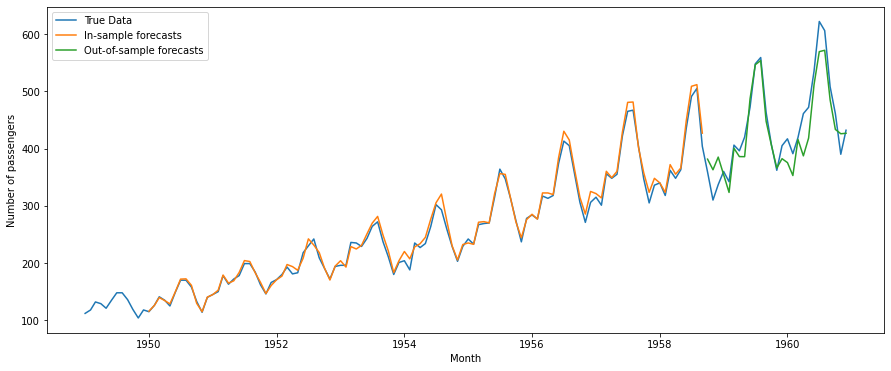

In [38]:
# In-sample and out of sample forecast 
allPredict = model.predict(Xall)

# Transform the forecast values to original scale
allPredictPlot = scaler.inverse_transform(allPredict)

# Extract in-sample forecast in original scale
Predict_in = allPredictPlot[:train_size]

# Extract out-of-sample forecast in original scale
Predict_out = allPredictPlot[-test_size:]

# Plot true and in-sample forecast values
plt.figure(figsize=(15,6))
plt.plot(data_raw.index, scaler.inverse_transform(data_scaled), label='True Data')
plt.plot(data_raw.index[-(train_size+test_size):-test_size],Predict_in, label='In-sample forecasts')
plt.plot(data_raw.index[-test_size:],Predict_out, label='Out-of-sample forecasts')
plt.xlabel('Month')
plt.ylabel('Number of passengers')
plt.legend()
plt.show()

<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- What is the purpose of `inverse_transform()` function?

Recall that we normalize the data before we feed-in them into the network. By calling this function, we could undo the scaling according to its feature_range. 

We can also calculate the train error and test error on scaled data as well as original data.

In [39]:
import math
trainScore_not_scaled = math.sqrt(mean_squared_error(Yall_not_scaled[:train_size], allPredictPlot[:train_size,0]))
print('Training Data RMSE on original scale: {0:.2f}'.format(trainScore_not_scaled))

testScore_not_scaled = math.sqrt(mean_squared_error(Yall_not_scaled[train_size:], allPredictPlot[train_size:,0]))
print('Test Data RMSE original scale: {0:.2f}'.format(testScore_not_scaled))

Training Data RMSE on original scale: 8.57
Test Data RMSE original scale: 31.59


<div style="margin-bottom: 0px;"><img width=20 style="display: block; float: left;  margin-right: 20px;" src="question-mark-button.png"> <h3 style="padding-top: 0px;">Question </h3></div>

- Is there any difference between train and test error? Why? 
- Can you suggest any way to minimize that difference?

# Task

## Task 1: 

In tutorial 11, we used feed forward neural network to forecast the time series. We used one hidden layer with 10 neurons. Now train this network with two hidden layers. Explore following two cases.

- Case 1: Each hidden layer will have 10 neurons
- Case 2: First hidden layer will have 14 neurons and the second hidden layer will have 6 neurons. Check train and test error for both cases and compare that with the implementation in the tutorial.

## Task 2 

Change the number of training epochs (`epochs`) to 500 and 1000 in both cases and then compare the result with tutorial implementation. Every time you are changing any parameter, make sure to restart the kernel. Otherwise, the training will be done on already trained model.

## Task 3

Given the trained NN model in section 7, obtain the forecast values for out-of-sample period with the assumption that only in-sample data are observed when doing forecast. This is a multi-step-ahead forecast problem, e.g. $[\widehat{Y}_{t+1|1:t},...,\widehat{Y}_{t+h|1:t}]$